## Triple-Barrier Method

금융 응용에서 좀 더 현실적인 방법은 포지션의 성패를 나타내는 label을 만드는 것이다. 포트폴리오 매니저가 채택하는 통상적인 거래 규칙은 (1) 미실현 이익목표가 달성되면 그 포지션이 성공으로 마감되며, (2) 미실현 손실 한계에 도달하면 실패로 종결되며, (3) 최대 수의 바까지 그 포지션의 실패도 성공도 없이 청산된다는 것이다. 포지션 성과의 시간 그래프에서 처음 두 조건은 2개의 수평 배리어를 정의하고, 세 번쨰 조건은 수직 배리어를 정의한다. 처음으로 접촉된 배리어와 관련된 바의 인덱스는 $t_{i,1}$로 기록된다. 이익이 나는 배리어를 먼저 건드리면 관측 결과를 $y_i = 1$로 표시한다. loss cut barrier가 먼저 닿으면 관측값을 $y_i = -1$로 표시한다. vertical barrier가 먼저 닿았을 때 우리는 두 가지 옵션을 갖고 있다. 그것을 $y_i = 0$으로 표시하거나 $y_i = \text{sgn}[r_{t_{i, 0}, t_{i,1}}]$으로 표시할 수 있다.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_date = '2000-01-01'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    progress = False,
    interval = '1d',
    multi_level_index = False,
    auto_adjust = False
)

profit taking과 loss cut barrier를 설정하려면 $i$번째 관측과 관련된 포지션 방향에 대한 지식이 필요하다. 포지션 방향을 알 수 없을 때 여전히 horizontal barrier를 바의 구간 $[t_{i,0}, t_{i,0}+h]$에 걸친 예측 변동성의 함수로 설정할 수 있다. 여기서 $h$는 vertical barrier가 접촉될 때까지의 바의 수이다. 이 경우에 barrier는 대칭적일 것이다. 왜냐하면 방향 정보 없이는 어떤 barrier가 이익을 의미하고 어떤 barrier가 손실을 의미하는지 알 수 없기 때문이다.

In [2]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [3]:
from FinancialMachineLearning.features.volatility import daily_volatility

volatility = daily_volatility(data['Close'], lookback = 20)

triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.017084,2,1
2000-01-10,2000-01-12,0.026742,2,1
2000-01-11,2000-01-12,0.024329,2,1
2000-01-12,2000-01-13,0.032377,2,1
2000-01-13,2000-01-20,0.054135,2,1


In [4]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [5]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.017084,-1
2000-01-10,-0.108056,0.026742,-1
2000-01-11,-0.059973,0.024329,-1
2000-01-12,0.109677,0.032377,1
2000-01-13,0.173127,0.054135,1


fixed-horizontal 기간 방식에 비한 triple barrier 방식의 주요 장점은 후자가 바 구간 $[t_{i,0}, t_{i,0}+h]$들에 걸친 경로에 대한 정보를 통합한다는 점이다. 실무적으로 투자 기회의 최대 보유 기간은 자연스럽게 정의할 수 있으며, $h$의 값은 주관적이지 않다. 한 가지 단점은 barrier에 접촉되는 것이 이산적 사건이라는 것인데 이것은 작은 마진으로 발생할 수도 있고, 그렇지 않을 수도 있다. 

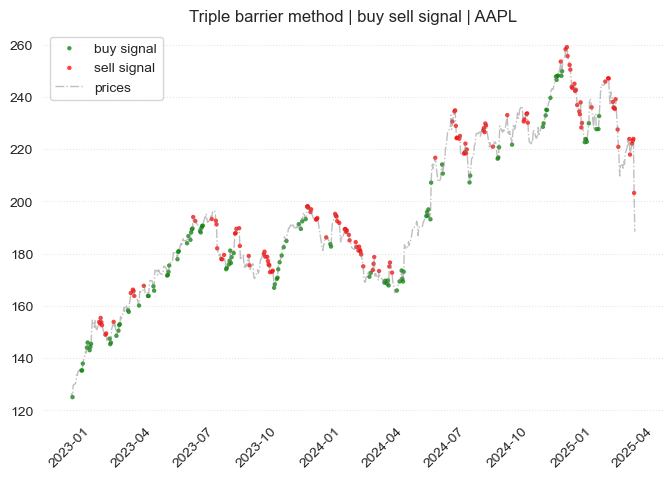

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1]['2023':].index,
    data.loc[labels[labels['bin'] == 1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.scatter(
    labels[labels['bin'] == -1]['2023':].index,
    data.loc[labels[labels['bin'] == -1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | buy sell signal | AAPL')
plt.show()